# FFT of oscillation traces

### User Input

In [9]:
strain = 'het_b'
freq_bands = [4,8]
ctr_f = '2020_01_22_0007.abf'
ctr_channel = 0
cell = 1
ctr_swps = [0]
ctr_start = 0 # in seconds
ctr_end = 120 # in seconds

nmda_f = '2020_01_22_0007.abf'
nmda_channel = ctr_channel
nmda_swps = [0]
nmda_start = 480
nmda_end = 560 # in sec

conc_nmda = 5
sample_rate = 10000 # in Hz
step = 2 * sample_rate # window size

ctr_start = ctr_start * sample_rate 
ctr_end = ctr_end * sample_rate 
nmda_start = nmda_start * sample_rate
nmda_end = nmda_end * sample_rate 

file_id = ctr_f + ' | ' + nmda_f



### Import Packages

In [10]:
import pyabf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import auc
import configparser
import scipy.fftpack

### Read in the ABF File

In [11]:
dir_in = os.getcwd()
dir_out = dir_in + '\\Analyzed'

ctr_abf = pyabf.ABF(ctr_f)   # Read in time series for the control condition
nmda_abf = pyabf.ABF(nmda_f)     # Read in time series for the nmda condition

print(len(nmda_abf.sweepX))
print(nmda_end)


6100000
5600000


### Function Definitions

In [12]:
def full_fft(abf, sweep, channel):
    abf.setSweep (sweepNumber = sweep-1, channel = channel)    
    x = abf.sweepX * sample_rate
    y = abf.sweepY
    sampling_interval = 1000/sample_rate

    # Frequency domain representation
    xform = np.fft.fft(y)/len(y) # Normalize amplitude
    xform = xform[range(int(len(y)/2))] # Exclude sampling frequency
    timepoints = len(y)
    values      = np.arange(int(timepoints/2))
    time_period  = timepoints/sample_rate
    frequencies = values/time_period

    #fig, ax = plt.subplots(figsize = (10,3), dpi= 100)
    #ax.plot(frequencies[2:], abs(xform)[2:])
    #ax.set_xlim(2,10)
    #ax.set_ylim (0,1)
    return frequencies[2:], abs(xform)[2:]

def part_fft(abf, sweep, channel, start, end):
    abf.setSweep (sweepNumber = 0, channel = channel)    
    x = abf.sweepX[start:end]/sample_rate
    y = abf.sweepY[start:end]
    sampling_interval = 1000/sample_rate

    # Frequency domain representation
    xform = np.fft.fft(y)/len(y) # Normalize amplitude
    xform = xform[range(int(len(y)/2))] # Exclude sampling frequency
    timepoints = len(y)
    values      = np.arange(int(timepoints/2))
    time_period  = timepoints/sample_rate
    frequencies = values/time_period

    #fig, ax = plt.subplots(figsize = (10,3), dpi= 100)
    #ax.plot(x,y)
    #ax.plot(frequencies[2:], abs(xform)[2:])
    #ax.set_xlim(2,10)
    #ax.set_ylim (0,1)
    return frequencies[2:], abs(xform)[2:]

### Continuous Control Condition: Get FFTs for each sweep in the list

Text(0, 0.5, 'Spectral Density (mV$^2$/Hz)')

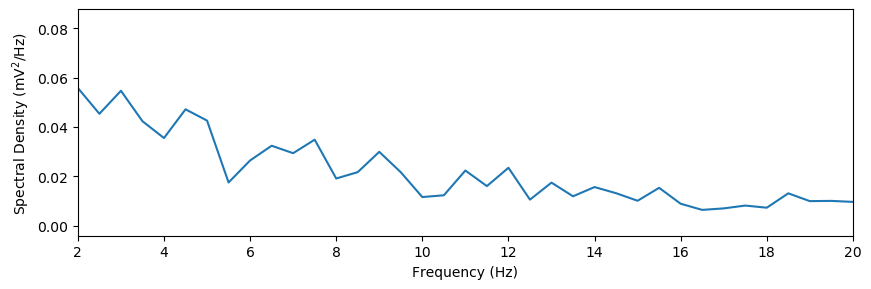

In [13]:
df_ctr = pd.DataFrame()
i = 0
win_start = ctr_start
while i < (nmda_end-nmda_start)/step:
    win_start = win_start + step
    win_end = win_start + step
    frequencies, xform = part_fft(ctr_abf, ctr_swps, ctr_channel, win_start, win_end)
    if i == 0:
        df_ctr['frequencies'] = frequencies
        df_ctr = df_ctr.set_index('frequencies')
        i = i + 1
    else:
        if len(frequencies) == len(df_ctr.index):
            df_ctr['sweep_'+str(ctr_swps)] = xform
            df_ctr['avg'] = df_ctr.mean(axis = 1)    
        else:
            i = ctr_end/step
    i = i + 1  
    
fig, ax = plt.subplots(figsize = (10,3), dpi= 100)
ax.plot(df_ctr.index.values, df_ctr.avg)
ax.set_xlim(2,20)
ax.set_xlabel ('Frequency (Hz)')
ax.set_ylabel ('Spectral Density (mV' + r'$^2$' + '/Hz)')
      
    


### Continuous NMDA Condition: Get FFTs for each sweep in the list

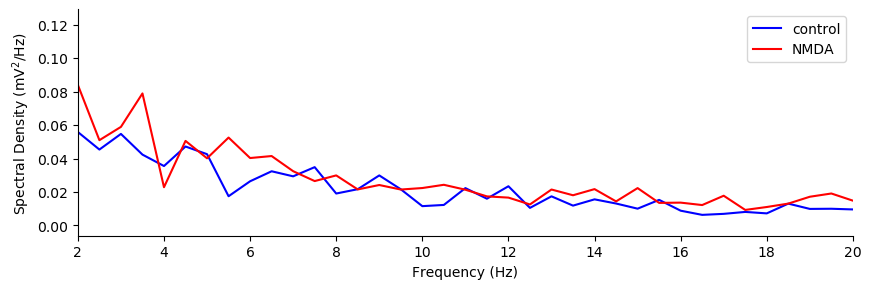

In [14]:
df_nmda = pd.DataFrame()
i = 0
win_start = nmda_start
while i < (nmda_end-nmda_start)/step:
    win_start = win_start + step
    win_end = win_start + step
    frequencies, xform = part_fft(nmda_abf, nmda_swps, nmda_channel, win_start, win_end)
    if i == 0:
        df_nmda['frequencies'] = frequencies
        df_nmda = df_nmda.set_index('frequencies')
        i = i + 1
    else:
        if len(frequencies) == len(df_nmda.index):
            df_nmda['sweep_'+str(nmda_swps)] = xform
            df_nmda['avg'] = df_nmda.mean(axis = 1)    
        else:
            i = nmda_end/step
    i = i + 1  
    
fig, ax = plt.subplots(figsize = (10,3), dpi= 100)
ax.plot(df_ctr.index.values, df_ctr.avg, color = "blue", label = 'control')
ax.plot(df_nmda.index.values, df_nmda.avg, color = "red", label = "NMDA")
ax.set_xlim(2,20)

ax.set_xlabel ('Frequency (Hz)')
ax.set_ylabel ('Spectral Density (mV' + r'$^2$' + '/Hz)')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

### Frequency Band Summary

In [15]:
# Wide Frequecy band (2-8 Hz)
# Peak spectral density
ctr_wide_peak = df_ctr.avg[2:8].max()
nmda_wide_peak = df_nmda.avg[2:8].max()
pchange_wide_peak = 100*(nmda_wide_peak - ctr_wide_peak)/ctr_wide_peak

# Mean spectral density
ctr_wide_mean = df_ctr.avg[2:8].mean()
nmda_wide_mean = df_nmda.avg[2:8].mean()
pchange_wide_mean = 100*(nmda_wide_mean - ctr_wide_mean)/ctr_wide_mean

# Narrow Frequency Band
# Peak Spectral Density
ctr_narrow_peak = df_ctr.avg[3:6].max()
nmda_narrow_peak = df_nmda.avg[3:6].max()
pchange_narrow_peak = 100*(nmda_narrow_peak - ctr_narrow_peak)/ctr_narrow_peak

# Mean Spectral Density
ctr_narrow_mean = df_ctr.avg[3:6].max()
nmda_narrow_mean = df_nmda.avg[3:6].max()
pchange_narrow_mean = 100*(nmda_narrow_mean - ctr_narrow_mean)/ctr_narrow_mean

df_out = pd.DataFrame ({"file_id": ctr_f + ' | ' + nmda_f, 
           'strain': strain,
           'cell': ctr_channel + 1,
           'conc_nmda': 5,
           'ctr_2to8hz_peak': [ctr_wide_peak],
           'nmda_2to8hz_peak': [nmda_wide_peak],
           'pchange_2to8hz_peak': [pchange_wide_peak],
           'ctr_2to8hz_mean': [ctr_wide_mean],
           'nmda_2to8hz_mean': [nmda_wide_mean],
           'pchange_2to8hz_mean': [pchange_wide_mean],
           'ctr_3to6hz_peak': [ctr_narrow_peak],
           'nmda_3to6hz_peak': [nmda_narrow_peak],
           'pchange_3to6hz_peak': [pchange_narrow_peak],    
           'ctr_3to6hz_mean': [ctr_narrow_mean],
           'nmda_3to6hz_mean': [nmda_narrow_mean],
           'pchange_3to6hz_mean': [pchange_narrow_mean]
          })
display(HTML(df_out.to_html()))

,file_id,strain,cell,conc_nmda,ctr_2to8hz_peak,nmda_2to8hz_peak,pchange_2to8hz_peak,ctr_2to8hz_mean,nmda_2to8hz_mean,pchange_2to8hz_mean,ctr_3to6hz_peak,nmda_3to6hz_peak,pchange_3to6hz_peak,ctr_3to6hz_mean,nmda_3to6hz_mean,pchange_3to6hz_mean
0,2020_01_22_0007.abf | 2020_01_22_0007.abf,het_b,1,5,0.055831,0.083936,50.339651,0.037158,0.046871,26.140077,0.054695,0.078872,44.202876,0.054695,0.078872,44.202876


### Save data to disk

In [16]:
fname_ctr = ctr_f.split('.abf')
df_ctr.to_csv(strain + '_Ch' + str(ctr_channel) + '_' + fname_ctr[0] + "_fft_ctr.csv", index = True)

fname_nmda = nmda_f.split('.csv')
df_nmda.to_csv(strain + '_Ch' + str(nmda_channel) + '_' + fname_nmda[0] + "_fft_nmda.csv", index = True)


### Upload Results to MySQL Database (personal siteground.com database)

In [11]:
import mysql.connector
from mysql.connector import errorcode
from ephyspy import mysql_manager 
import configparser

config = configparser.ConfigParser()
config.read('sg_config.ini')
DB_NAME = config.get('connections', 'DB_NAME')
USER_NAME = config.get('connections', 'DB_USER')
PWD = config.get('connections', 'DB_PWD')
HOST_NAME = config.get('connections','DB_HOST')
PORT = config.get('connections', 'DB_PORT')

cnx = mysql.connector.connect(user = USER_NAME, 
    password = PWD, host = HOST_NAME, database = DB_NAME, 
    port = PORT)
cursor = cnx.cursor(buffered = True)

mysql_manager.locate_database(cursor, DB_NAME)

fields = ['file_id',
          'strain', 
          'cell',
          'conc_nmda', 
          'ctr_2to8hz_peak',
          'nmda_2to8hz_peak',
          'pchange_2to8hz_peak',
          'ctr_2to8hz_mean',
          'nmda_2to8hz_mean',
          'pchange_2to8hz_mean',
          'ctr_3to6hz_peak',
          'nmda_3to6hz_peak',
          'pchange_3to6hz_peak',
          'ctr_3to6hz_mean',
          'nmda_3to6hz_mean',
          'pchange_3to6hz_mean']
data = [file_id,
          strain, 
          cell,
          conc_nmda, 
          float(ctr_wide_peak),
          float(nmda_wide_peak),
          float(pchange_wide_peak),
          float(ctr_wide_mean),
          float(nmda_wide_mean),
          float(pchange_wide_mean),
          float(ctr_narrow_peak),
          float(nmda_narrow_peak),
          float(pchange_narrow_peak),
          float(ctr_narrow_mean),
          float(nmda_narrow_mean),
          float(pchange_narrow_mean)]


sql = "INSERT INTO fft ("+ ','.join(fields) + ') VALUES (' + ','.join(['%s']*len(fields)) + ')'
print (sql)
cursor.execute(sql, data)
cnx.commit()

cnx.commit()

cnx.close()

Data base haleygee_olive  is alive.
INSERT INTO fft (file_id,strain,cell,conc_nmda,ctr_2to8hz_peak,nmda_2to8hz_peak,pchange_2to8hz_peak,ctr_2to8hz_mean,nmda_2to8hz_mean,pchange_2to8hz_mean,ctr_3to6hz_peak,nmda_3to6hz_peak,pchange_3to6hz_peak,ctr_3to6hz_mean,nmda_3to6hz_mean,pchange_3to6hz_mean) VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)


### Upload Results to azure database

In [12]:
import pyodbc

f_config = 'config.ini'
config = configparser.ConfigParser()
config.read(f_config)
username = config.get('connections', 'DB_USER')
server = config.get('connections', 'DB_HOST')
database = config.get('connections', 'DB_NAME')
password = config.get('connections', 'DB_PWD')
server = config.get('connections','DB_HOST')
driver = config.get('connections', 'DB_DRIVER')
print (server, database, password, server, driver)

cnxn = pyodbc.connect('DRIVER='+driver+';SERVER='+server+';PORT=1433;DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()

fields = ['file_id','strain', 'cell','conc_nmda', 'ctr_2to8hz_peak','nmda_2to8hz_peak','pchange_2to8hz_peak',
          'ctr_2to8hz_mean','nmda_2to8hz_mean','pchange_2to8hz_mean','ctr_3to6hz_peak','nmda_3to6hz_peak',
          'pchange_3to6hz_peak','ctr_3to6hz_mean','nmda_3to6hz_mean','pchange_3to6hz_mean']

data = [ctr_f + ' | ' + nmda_f, strain, ctr_channel + 1, 5, ctr_wide_peak, nmda_wide_peak, pchange_wide_peak, 
        ctr_wide_mean, nmda_wide_mean, pchange_wide_mean, ctr_narrow_peak,nmda_narrow_peak, pchange_narrow_peak, 
        ctr_narrow_mean,nmda_narrow_mean,pchange_narrow_mean]

sql = "INSERT INTO fft ("+ ','.join(fields) + ') VALUES (' + ','.join(['?']*len(fields)) + ')'

cursor.execute(sql, data)
cursor.commit()

haleygeek.database.windows.net slices TacoT0wn! haleygeek.database.windows.net {SQL Server}
